In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance
import tqdm
import plotly.express as px
import plotly.graph_objects as go
import datetime

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pdoub\Desktop\python_projects\junk-draw

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")
df.reset_index(inplace=True, drop=True)
df.sort_index(inplace=True)

In [4]:
df.shape

(5000, 14)

In [5]:
df.tail(2)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title
4998,4994,1475721018,https://www.reddit.com/r/legaladvice/comments/...,5639t2,I will preface this by admitting I'm an idiot ...,"(CO) First Ticket ever, Careless Driving",driving,4,"[0.004459863429254688, 0.003479491143272819, 0...",209,"""Legal options for a teenager facing a Careles...",NJ,10,Legal Topics in Traffic Violations
4999,8627,1589322350,https://www.reddit.com/r/legaladvice/comments/...,gilww3,Hey folks;\n\nI'm currently designing a video ...,[OH] Advice on safe contracts for freelancers/...,contract,1,"[0.010599094232140971, -0.01940659953784975, -...",191,"""Protecting Intellectual Property and Ensuring...",OR,6,Compilation of Legal Topics


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

class TopicEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, text_col, threshold=0.1):
        self.text_col = text_col
        self.threshold = threshold
        self.vectorizer_model = CountVectorizer(stop_words = 'english')
        self.topic_model = BERTopic(
            vectorizer_model = self.vectorizer_model,
            nr_topics = 'auto',
            calculate_probabilities=True)

    def fit(self, X, y=None):
        docs = list(X[self.text_col])
        self.topic_model.fit(docs)
        return self

    def transform(self, X):
        docs = list(X[self.text_col])
        # X = X.join(self.topic_model.get_document_info(docs))
        topic_distr, _ = self.topic_model.approximate_distribution(docs, window = 4, calculate_tokens=True)
        X['multiple_topics'] = list(map(
            lambda doc_topic_distr: list(map(
                lambda y: y[0], filter(lambda x: x[1] >= self.threshold, 
                                    (enumerate(doc_topic_distr)))
            )), topic_distr
        ))
        X = self.one_hot_encode_topics(X, 'multiple_topics')
        return X

    def one_hot_encode_topics(self, df, column_name):
        df[column_name] = df[column_name].astype('string')
        one_hot_list = []
        for idx, row in df.iterrows():
            topics = eval(row[column_name])
            one_hot_row = {}
            for topic in topics:
                one_hot_row[f'topic_{topic}'] = 1
            one_hot_list.append(one_hot_row)
        one_hot_df = pd.DataFrame(one_hot_list)
        one_hot_df.fillna(0, inplace=True)
        one_hot_df = one_hot_df.astype(int)

        # Sort the columns
        one_hot_df = one_hot_df.sort_index(axis=1)

        df.reset_index(drop=True, inplace=True)
        df = pd.concat([df, one_hot_df], axis=1)
        return df

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from fastembed.embedding import FlagEmbedding as Embedding
import umap
import numpy as np

class EmbeddingUmapTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column, model_name="BAAI/bge-base-en-v1.5", max_length=512, n_neighbors=10, metric='cosine', min_dist=0.0, n_components=5):
        self.text_column = text_column
        self.model_name = model_name
        self.max_length = max_length
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.min_dist = min_dist
        self.n_components = n_components
        self.umap_model = umap.UMAP(angular_rp_forest=True, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, n_components=n_components)

    def fit(self, X, y=None):
        self.embedding_model = Embedding(model_name=self.model_name, max_length=self.max_length)
        documents = ("passage: " + text for text in X[self.text_column])
        embeddings = self.embedding_model.embed(documents)
        self.umap_model.fit(np.vstack(embeddings))
        return self

    def transform(self, X):
        self.embedding_model = Embedding(model_name=self.model_name, max_length=self.max_length)
        documents = ("passage: " + text for text in X[self.text_column])
        embeddings = self.embedding_model.embed(documents)
        reduced_embeddings = self.umap_model.transform(np.vstack(embeddings))
        for i in range(reduced_embeddings.shape[1]):
            X[f'umap_{i}'] = reduced_embeddings[:, i]
        return X

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from keyphrase_vectorizers import KeyphraseCountVectorizer
import spacy
from keybert import KeyBERT
from collections import Counter

class KeywordVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=None, text_col_name=None):
        self.max_features = max_features
        self.text_col_name = text_col_name
        self.nlp = spacy.load("en_core_web_lg")
        self.kw_model = KeyBERT(model=self.nlp)
        self.vectorizer = KeyphraseCountVectorizer(
            spacy_pipeline=self.nlp,
            )
        self.vectorizer_model = None
        self.vocabulary = None

    def fit(self, X, y=None):
        docs = X[self.text_col_name]
        keywords = self.kw_model.extract_keywords(
            docs,
            vectorizer=self.vectorizer,
            top_n=10,
            use_mmr=True)
        keyword_counts = Counter(k[0] for keyword in keywords for k in keyword)
        self.vocabulary = [k for k, _ in keyword_counts.most_common(self.max_features)]
        self.vectorizer_model = TfidfVectorizer(vocabulary=self.vocabulary)
        self.vectorizer_model.fit(docs)
        return self

    def transform(self, X):
        df = X.copy()
        vectors = self.vectorizer_model.transform(df[self.text_col_name])
        new_columns = pd.DataFrame(vectors.toarray(), columns=['count_vec_' + str(i) for i in range(vectors.shape[1])])
        df.reset_index(drop=True, inplace=True)
        df = pd.concat([df, new_columns], axis=1)
        return df


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
import textacy
import coreferee
from collections import Counter
from gensim.models import FastText
import spacy.cli
import networkx as nx
import community as community_louvain

import matplotlib.pyplot as plt

def check_and_install_spacy_models(models):
    for model in models:
        try:
            # Try to load the model
            spacy.load(model)
        except OSError:
            # If model is not installed, download and install it
            print(f"{model} not found. Downloading and installing...")
            spacy.cli.download(model)
# List of models to check and install
models = ["en_core_web_md", "en_core_web_lg"]

check_and_install_spacy_models(models)

class TripleExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_column, risk_keywords, n_top_triples=20, corpus=None):
        self.nlp = spacy.load("en_core_web_lg")
        self.nlp1 = spacy.load('en_core_web_lg')
        self.nlp1.add_pipe('coreferee')
        self.nlp1 = spacy.load("en_core_web_lg")
        if "coreferee" not in self.nlp1.pipe_names:
            self.nlp1.add_pipe('coreferee')
        self.nlp2 = spacy.load("en_core_web_md")
        self.text_column = text_column
        self.risk_keywords = risk_keywords
        self.n_top_triples = n_top_triples
        self.corpus = corpus
        self.top_triples = None
        self.risk_triples = None
        
        # If a corpus is provided, train Word2Vec on it
        if corpus:
            sentences = [text.split() for text in corpus]
            self.fasttext_model = FastText(sentences, window=5, min_count=1, workers=4)    
    
    def fit(self, X, y=None):
        # Extract all triplets from the training data
        self.all_triples = self._extract_all_triples(X[self.text_column])
        
        # Find the most common triplets
        triple_counter = Counter(self.all_triples)
        self.top_triples = [triple for triple, count in triple_counter.most_common(self.n_top_triples)]
        
        # Find the risk-related triplets
        self.risk_triples = [triple for triple in self.all_triples if any(self.fasttext_model.wv.similarity(keyword, word) > 0.8 for word in triple for keyword in self.risk_keywords)]
        
        # Generate graph and calculate eigenvector centrality
        self.G = self._generate_graph(self.all_triples)
        self.partition = community_louvain.best_partition(self.G)
        
        return self
    
    def transform(self, X):
        # Adding community as node attributes
        nx.set_node_attributes(self.G, self.partition, 'community')
        # Convert to DataFrame
        features_df = pd.DataFrame.from_dict(dict(self.G.nodes(data=True)), orient='index')
        # Map communities back to documents
        community_series = pd.Series(X[self.text_column].apply(lambda doc: self._get_document_community(doc, features_df)), name='community')
        
        # Initialize a dictionary to store the counts of each risk keyword
        risk_keyword_counts = {keyword: [] for keyword in self.risk_keywords}
        top_feature_vectors = []
        for texts in tqdm.tqdm(X[self.text_column]):
            text_triples = self._extract_triples_from_text(texts)
            top_features = [int(triple in text_triples) for triple in self.top_triples]
            top_feature_vectors.append(top_features)
            # Count the occurrences of each risk keyword in the text triples
            for keyword in self.risk_keywords:
                risk_keyword_counts[keyword].append(sum(keyword in triple for triple in text_triples))
        # Convert the dictionary to a DataFrame
        risk_keyword_df = pd.DataFrame(risk_keyword_counts)
        
        # Convert the lists of feature vectors to DataFrames
        top_feature_df = pd.DataFrame(top_feature_vectors, columns=["top_triples_" + str(triple) for triple in self.top_triples])
        
        # Clean the column names in the top_feature_df
        top_feature_df.columns = top_feature_df.columns.str.lower().str.replace(' ', '_').str.replace('[^a-z0-9_]', '').str.replace("('", "").str.replace("',_'", "_").str.replace("')", "")
        
        # Concatenate the new features to the original DataFrame
        X_extended = pd.concat([X.reset_index(drop=True), top_feature_df, risk_keyword_df, community_series.reset_index(drop=True)], axis=1)
        
        return X_extended
    
    def _get_document_community(self, doc, features_df):
        words = doc.split()
        communities = [features_df.loc[word, 'community'] for word in words if word in features_df.index]
        # Here we simply return the most common community, could also consider other aggregation methods
        return max(set(communities), key=communities.count)
    
    def _extract_all_triples(self, X):
        # This method extracts all triplets from a list of texts
        all_triples = []
        for texts in X:
            text_triples = self._extract_triples_from_text(texts)
            all_triples.extend(text_triples)
        return all_triples

    def _extract_triples_from_text(self, text):
        triples = []

        # Coreference resolution
        text = self.coref_resolve(text)

        # Split compound sentences into simple sentences
        simple_sentences = self.compound_to_simple(text)

        for sentence in simple_sentences:
            doc = self.nlp(sentence)
            svo_triples = list(textacy.extract.subject_verb_object_triples(doc))
            for triple in svo_triples:
                subj = "_".join(map(str, triple.subject))
                obj = "_".join(map(str, triple.object))
                verb = "_".join(map(str, triple.verb))
                triples.append((subj, verb, obj))
        return triples

    def coref_resolve(self, text):
        doc1 = self.nlp1(text)
        tok_list = list(token.text for token in doc1)
        c = 0
        for chain in doc1._.coref_chains:
            for mention in chain:
                res1 = [doc1._.coref_chains.resolve(doc1[i]) for i in mention]
                res = [r for r in res1 if r is not None]
                if len(res) != 0:
                    if len(res[0]) == 1:
                        tok_list[mention[0] + c] = str(res[0][0])
                    elif len(res[0]) > 1:
                        tok_list[mention[0] + c] = str(res[0][0])
                        for j in range(1, len(res[0])):
                            tok_list.insert(mention[0] + c + j, str(res[0][j]))
                            c = c + 1
        textres = " ".join(tok_list)
        return textres

    def compound_to_simple(self, sentence):
        doc = self.nlp2(sentence)
        root_token = None
        for token in doc:
            if (token.dep_ == "ROOT"):
                root_token = token
        other_verbs = []
        for token in doc:
            ancestors = list(token.ancestors)
            if (token.pos_ == "VERB" and len(ancestors) < 3 and token != root_token):
                other_verbs.append(token)
        token_spans = []
        all_verbs = [root_token] + other_verbs
        for other_verb in all_verbs:
            first_token_index = len(doc)
            last_token_index = 0
            this_verb_children = list(other_verb.children)
            for child in this_verb_children:
                if (child not in all_verbs):
                    if (child.i < first_token_index):
                        first_token_index = child.i
                    if (child.i > last_token_index):
                        last_token_index = child.i
            token_spans.append((first_token_index, last_token_index))
        sentence_clauses = []
        for token_span in token_spans:
            start = token_span[0]
            end = token_span[1]
            if (start < end):
                clause = doc[start:end]
                sentence_clauses.append(clause)
        sentence_clauses = sorted(sentence_clauses, key=lambda tup: tup[0])
        clauses_text = [clause.text for clause in sentence_clauses]
        return clauses_text
    
    def visualize_knowledge_graph(self, use_top_triples=True):
        if use_top_triples:
            if self.top_triples is None:
                raise ValueError("No top triples available. Please run the fit method first.")
            triples = self.top_triples
        else:
            if self.all_triples is None:
                raise ValueError("No all triples available. Please run the fit method first.")
            triples = self.all_triples

        KG = nx.DiGraph()
        for triple in triples:
            KG.add_edge(triple[0], triple[2], relation=triple[1])

        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(KG)
        nx.draw(KG, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
        plt.show()
        
    
    def _generate_graph(self, triples):
        # Create a graph from the triples
        G = nx.Graph()  # Changed from nx.DiGraph() to nx.Graph() for non-directed graph
        for triple in triples:
            G.add_edge(triple[0], triple[2], relation=triple[1])

        return G


In [61]:
risk_keywords = ["liability", "insurance", "should_do"]

corpus_ = df['body'].tolist()
corpus = [d for d in corpus_]

In [78]:
triplet_extractor = TripleExtractor(
        'body', 
        risk_keywords=risk_keywords, 
        n_top_triples=10, 
        corpus=corpus)

In [86]:
test_df = df.sample(100)

In [79]:
triplet_extractor.fit(test_df)

TripleExtractor(corpus=['I applied for a job and after two interviews I was '
                        'given for and agreed to an offer letter, had a start '
                        'date.  The only remaining variable was a drug test, '
                        'which I prepared myself for by bringing all my '
                        'prescriptions with me.  \n'
                        '\n'
                        'I take Adderall, my doctor prescribes me for 3 pills '
                        'a day, insurance pays for only two a day so that’s '
                        'what I get.  2 pills a day for 30 days.  \n'
                        '\n'
                        'How...
                        'I’ve posted this multiple times and the moderator '
                        'keeps removing me for no reason. You’d think '
                        'something representing something for LEGAL ADVICE '
                        'would help someone looking for LEGAL ADVICE but '
                        'apparently not \n'
                        '\n'
                        'I want to know this answer I don’t see what’s wrong '
                        'with that. I GENUINELY don’t', ...],
                n_top_triples=10,
                risk_keywords=['liability', 'insurance', 'should_do'],
                text_column='body')

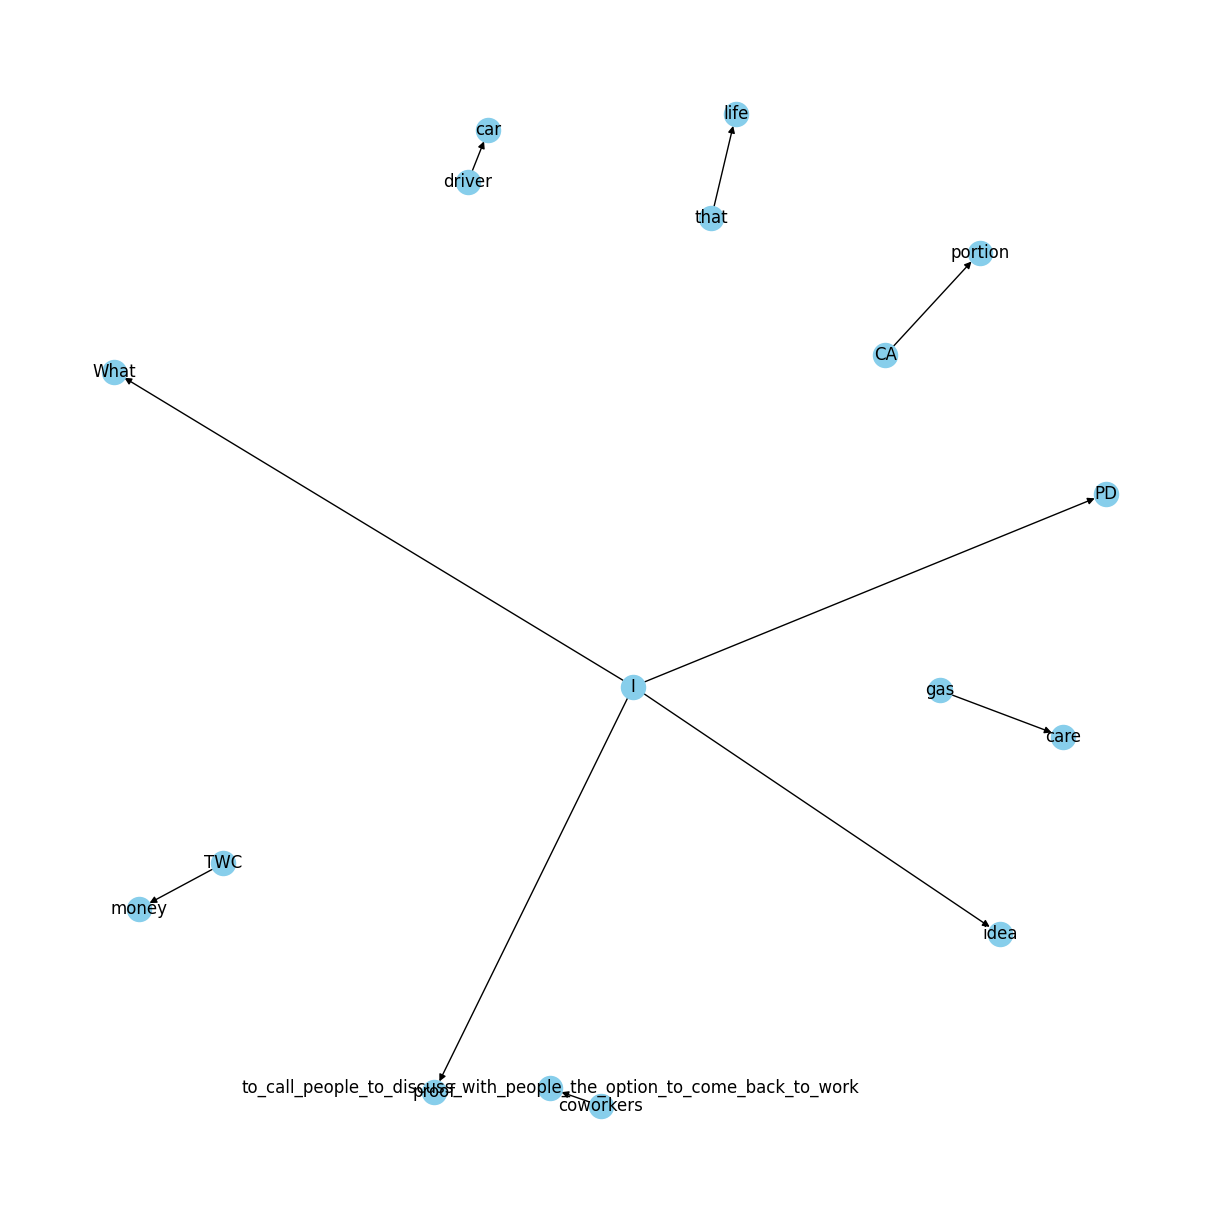

In [27]:
# To visualize all_triples
triplet_extractor.visualize_knowledge_graph(use_top_triples=True)

In [87]:
X_train_transformed = triplet_extractor.transform(test_df)

100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


In [89]:
X_train_transformed.community.value_counts()

community
12    62
0     19
5      7
3      6
6      5
1      1
Name: count, dtype: int64

In [82]:
X_train_transformed.tail(3)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,community,top_triples_i_got_ticket,top_triples_i_have_idea,top_triples_him_sold_house,top_triples_company_determine_service_charge,top_triples_we_had_taken_rest,top_triples_salon_owners_slam_post,top_triples_i_can_do_what,top_triples_i_can_use_they,top_triples_bosses_could_have_told_me,top_triples_i_’ll_call_friend,liability,insurance,should_do,community
97,7037,1575909169,https://www.reddit.com/r/legaladvice/comments/...,e8c817,My friend is getting charges at my school afte...,Boy at school having charges pressed by a slan...,school,9,"[-0.003290679088334908, 0.01536777529594581, 0...",279,"""Legal options for a student facing false char...",KY,9,Legal Consequences of False Accusations,13,0,0,0,0,0,0,0,0,0,0,0,0,0,12
98,5459,1588556951,https://www.reddit.com/r/legaladvice/comments/...,gd2on4,Someone sold their car to my friend and when ...,Washington car selling scam,criminal,2,"[-0.013662756830573507, -0.006139676736464661,...",67,"""Legal recourse for stolen car sold without ti...",IL,2,Car Accident Liability and Insurance,1,0,0,0,0,0,0,0,0,0,0,0,0,0,12
99,8275,1590729422,https://www.reddit.com/r/legaladvice/comments/...,gsmm2i,I am a student of engineering in India. We hav...,Possible cheating scam,school,9,"[-0.012260849017700429, -0.010401252032442266,...",395,"""Academic Assistance or Cheating? Navigating t...",PA,9,Legal Consequences of False Accusations,27,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [52]:
X_train_transformed.describe()

,index,created_utc,flair_label,token_count,kmeans_label,top_triples_i_can_do_what,top_triples_we_entered_customers,top_triples_i_should_do_what,top_triples_i_has_job,top_triples_i_may_leave_one,top_triples_mail_says_ship,top_triples_we_got_mom_daughter,top_triples_i_set_house,top_triples_who_has_dementia,top_triples_i_bought_motorcycle,liability,insurance,should_do
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,100.000000,100.000000
mean,4807.470000,1.541704e+09,5.210000,252.210000,5.310000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.080000,0.040000
std,2743.265622,6.165467e+07,2.709113,201.191315,3.086939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171447,0.393893,0.196946
min,23.000000,1.410988e+09,0.000000,25.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,2636.500000,1.515880e+09,3.000000,102.500000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,4809.500000,1.576563e+09,5.000000,188.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,7228.750000,1.589274e+09,7.000000,339.750000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,9421.000000,1.591197e+09,10.000000,894.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.000000,1.000000


In [50]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class TemporalEntityFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, entity_col='Entity', time_col='Time', value_col='Value'):
        self.entity_col = entity_col
        self.time_col = time_col
        self.value_col = value_col
        self.entity_history = {}
        
    def fit(self, X, y=None):
        X_sorted = X.sort_values([self.entity_col, self.time_col])
        
        for entity, group in X_sorted.groupby(self.entity_col):
            entity_history = group.sort_values(self.time_col).to_dict(orient='list')
            self.entity_history[entity] = entity_history
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['times_appeared_prior'] = 0
        X_transformed['distinct_times_appeared'] = 0
        X_transformed['mean_value_prior'] = 0.0
        
        for i, row in X_transformed.iterrows():
            entity = row[self.entity_col]
            current_time = row[self.time_col]
            
            if entity in self.entity_history:
                history = self.entity_history[entity]
                prior_idx = [i for i, time in enumerate(history[self.time_col]) if time < current_time]
                
                if prior_idx:
                    X_transformed.at[i, 'times_appeared_prior'] = len(prior_idx)
                    X_transformed.at[i, 'distinct_times_appeared'] = len(set(history[self.time_col][i] for i in prior_idx))
                    X_transformed.at[i, 'mean_value_prior'] = sum(history[self.value_col][i] for i in prior_idx) / len(prior_idx)
                    
        return X_transformed



In [51]:
# Sample data
train_data = {
    'Entity': ['A', 'A', 'A', 'B', 'B', 'C', 'C'],
    'Time': pd.to_datetime(['2001-01-01', '2002-06-15', '2003-03-20', '2001-02-28', '2003-08-15', '2002-12-01', '2003-05-10']),
    'Value': [10, 20, 10, 5, 15, 30, 20]
}

train_df = pd.DataFrame(train_data)

# Create and fit the transformer
entity_feature_transformer = TemporalEntityFeatureTransformer(entity_col='Entity', time_col='Time', value_col='Value')
entity_feature_transformer.fit(train_df)

# Transform the data
train_transformed = entity_feature_transformer.transform(train_df)

print("Transformed Training Data:")
print(train_transformed)

Transformed Training Data:
  Entity       Time  Value  times_appeared_prior  distinct_times_appeared  \
0      A 2001-01-01     10                     0                        0   
1      A 2002-06-15     20                     1                        1   
2      A 2003-03-20     10                     2                        2   
3      B 2001-02-28      5                     0                        0   
4      B 2003-08-15     15                     1                        1   
5      C 2002-12-01     30                     0                        0   
6      C 2003-05-10     20                     1                        1   

   mean_value_prior  
0               0.0  
1              10.0  
2              15.0  
3               0.0  
4               5.0  
5               0.0  
6              30.0  


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X_train, X_test = train_test_split(df, test_size=0.4, random_state=42)

In [25]:
risk_keywords = ["liability", "insurance", "should_do"]

corpus_ = df['body'].tolist()
corpus = [d for d in corpus_]

pipeline = Pipeline([
    ('topic_encoder', TopicEncoder(text_col="body")),
    ('kw_count_vectorizer', KeywordVectorizer(max_features=50, text_col_name="body")),
    ('triplet_extractor', TripleExtractor(
        'body', 
        risk_keywords=risk_keywords, 
        n_top_triples=10, 
        corpus=corpus)),
    ('umap_embedder', EmbeddingUmapTransformer(text_column="body"))
],
    verbose=True
)


In [26]:
test_df = df.sample(100)

In [27]:
pipeline.fit(test_df)

[Pipeline] ..... (step 1 of 4) Processing topic_encoder, total=   5.8s
[Pipeline]  (step 2 of 4) Processing kw_count_vectorizer, total=  11.1s


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


[Pipeline] . (step 3 of 4) Processing triplet_extractor, total=  50.2s
[Pipeline] ..... (step 4 of 4) Processing umap_embedder, total=  32.3s


Pipeline(steps=[('topic_encoder', TopicEncoder(text_col='body')),
                ('kw_count_vectorizer',
                 KeywordVectorizer(max_features=50, text_col_name='body')),
                ('triplet_extractor',
                 TripleExtractor(corpus=['I applied for a job and after two '
                                         'interviews I was given for and '
                                         'agreed to an offer letter, had a '
                                         'start date.  The only remaining '
                                         'variable was a drug test, which I '
                                         'prepared myself for by b...
                                         'no reason. You’d think something '
                                         'representing something for LEGAL '
                                         'ADVICE would help someone looking '
                                         'for LEGAL ADVICE but apparently '
                                         'not \n'
                                         '\n'
                                         'I want to know this answer I don’t '
                                         'see what’s wrong with that. I '
                                         'GENUINELY don’t', ...],
                                 n_top_triples=10,
                                 risk_keywords=['liability', 'insurance',
                                                'should_do'],
                                 text_column='body')),
                ('umap_embedder',
                 EmbeddingUmapTransformer(text_column='body'))],
         verbose=True)

In [28]:
test_res = pipeline.transform(test_df)

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


In [29]:
test_res.head(3)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,multiple_topics,topic_0,topic_1,topic_2,count_vec_0,count_vec_1,count_vec_2,count_vec_3,count_vec_4,count_vec_5,count_vec_6,count_vec_7,count_vec_8,count_vec_9,count_vec_10,count_vec_11,count_vec_12,count_vec_13,count_vec_14,count_vec_15,count_vec_16,count_vec_17,count_vec_18,count_vec_19,count_vec_20,count_vec_21,count_vec_22,count_vec_23,count_vec_24,count_vec_25,count_vec_26,count_vec_27,count_vec_28,count_vec_29,count_vec_30,count_vec_31,count_vec_32,count_vec_33,count_vec_34,count_vec_35,count_vec_36,count_vec_37,count_vec_38,count_vec_39,count_vec_40,count_vec_41,count_vec_42,count_vec_43,count_vec_44,count_vec_45,count_vec_46,count_vec_47,count_vec_48,count_vec_49,top_triples_i_should_do_what,top_triples_retailer_canceled_order,top_triples_someone_does_not_plan_to_follow_through_with_the_contract,top_triples_someone_will_file_claims_case,top_triples_lawyer_had_chance,top_triples_that_did_consultation,top_triples_i_sent_retainer_agreement,top_triples_realities_do_not_reflect_commitments,top_triples_that_could_change_lives,top_triples_boss_pulled_girlfriend,liability,insurance,should_do,umap_0,umap_1,umap_2,umap_3,umap_4
0,524,1589605242,https://www.reddit.com/r/legaladvice/comments/...,gkoyov,Signed a 2 month sublease with someone in earl...,Sublease Situation,housing,7,"[-0.017685881931148586, -0.007538027247924855,...",154,"""Legal implications of breaking a sublease agr...",KS,0,Legal Topics in Rental Properties,[0],1,0,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.803133,0.297535,0.356883,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.372940,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,0,1,1,0,0,0,0,0,0,0,0,0,12.023789,7.921834,2.969897,8.038216,4.074813
1,6114,1423295631,https://www.reddit.com/r/legaladvice/comments/...,2v2pbi,"Hey guys, long time (non-lawyer) lurker of the...","[US-TN] Just retained an attorney, what do I n...",family,6,"[-0.0018092953279340005, 0.021173241331556625,...",986,"""Key considerations for hiring a family law at...",ID,7,Child Custody and Related Issues,"[0, 2]",1,0,1,0.000000,0.0,0.316155,0.427604,0.0,0.104528,0.182365,0.115107,0.100197,0.0,0.0,0.0,0.418111,0.0,0.000000,0.000000,0.000000,0.511492,0.102298,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.192644,0.0,0.0,0.0,0.106901,0.00000,0.0,0.0,0.0,0.0,0.243622,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.140596,0.251371,0.000000,0.0,0.0,0.109438,0,0,0,0,1,1,1,1,0,0,0,0,0,9.225992,7.186953,3.447510,9.862123,4.102845
2,564,1590688682,https://www.reddit.com/r/legaladvice/comments/...,gsb52f,My boyfriend has a 3 year old daughter current...,Moving A Child Out of State (Oklahoma),family,6,"[0.0077508327692643215, 0.016073830068795918, ...",227,"""Seeking advice on relocating with a child ami...",MT,7,Child Custody and Related Issues,"[0, 2]",1,0,1,0.268185,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.290271,0.000000,0.280948,0.000000,0.000000,0.0,0.0,0.0,0.336988,0.0,0.0,0.0,0.317301,0.0,0.0,0.0,0.000000,0.37918,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.414029,0.0,0.0,0.0,0.0,0.000000,0.000000,0.485231,0.0,0.0,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,9.366739,7.134408,3.828840,9.549561,4.231846


In [35]:
df_test = test_res.iloc[:, 14:]


In [36]:
test_res['target'] = np.where(test_res['text_label']=="employment", 1, 0)

In [31]:
from feature_engine.selection import ProbeFeatureSelection
from sklearn.ensemble import RandomForestClassifier

In [32]:
sel = ProbeFeatureSelection(
    estimator=RandomForestClassifier(),
    variables=None,
    scoring="precision",
    n_probes=1,
    distribution="normal",
    cv=5,
    random_state=150,
    confirm_variables=False
)

In [37]:
sel.fit(df_test, test_res['target'])

ProbeFeatureSelection(estimator=RandomForestClassifier(), random_state=150,
                      scoring='precision')

In [39]:
sel.feature_importances_.head(10)

topic_0        0.008615
topic_1        0.011466
topic_2        0.005186
count_vec_0    0.014294
count_vec_1    0.004861
count_vec_2    0.013218
count_vec_3    0.016269
count_vec_4    0.007265
count_vec_5    0.014331
count_vec_6    0.007042
dtype: float64

In [40]:
sel.features_to_drop_

['topic_0',
 'topic_1',
 'topic_2',
 'count_vec_0',
 'count_vec_1',
 'count_vec_2',
 'count_vec_3',
 'count_vec_4',
 'count_vec_5',
 'count_vec_6',
 'count_vec_7',
 'count_vec_9',
 'count_vec_10',
 'count_vec_11',
 'count_vec_12',
 'count_vec_13',
 'count_vec_14',
 'count_vec_15',
 'count_vec_16',
 'count_vec_17',
 'count_vec_18',
 'count_vec_19',
 'count_vec_20',
 'count_vec_21',
 'count_vec_22',
 'count_vec_23',
 'count_vec_24',
 'count_vec_25',
 'count_vec_26',
 'count_vec_27',
 'count_vec_28',
 'count_vec_29',
 'count_vec_30',
 'count_vec_31',
 'count_vec_32',
 'count_vec_33',
 'count_vec_34',
 'count_vec_35',
 'count_vec_36',
 'count_vec_37',
 'count_vec_38',
 'count_vec_39',
 'count_vec_40',
 'count_vec_41',
 'count_vec_42',
 'count_vec_43',
 'count_vec_44',
 'count_vec_45',
 'count_vec_46',
 'count_vec_47',
 'count_vec_48',
 'count_vec_49',
 'top_triples_i_should_do_what',
 'top_triples_retailer_canceled_order',
 'top_triples_someone_does_not_plan_to_follow_through_with_the_cont